# Test PDPbox with Regression problem
## Kaggle Rossmann store with RandomForest regressor
This demo is based on **Rossmann Store Sales**  
https://www.kaggle.com/c/otto-group-product-classification-challenge

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from pdpbox import pdp, get_dataset, info_plots

# get dataset and model

In [2]:
test_ross = get_dataset.ross()
test_ross.keys()

['data', 'features', 'rf_model', 'target']

In [3]:
ross_data = test_ross['data']
ross_features = test_ross['features']
ross_model = test_ross['rf_model']
ross_target = test_ross['target']

In [4]:
ross_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# 1. Binary feature: SchoolHoliday

## 1.1 target distribution through feature 'SchoolHoliday'

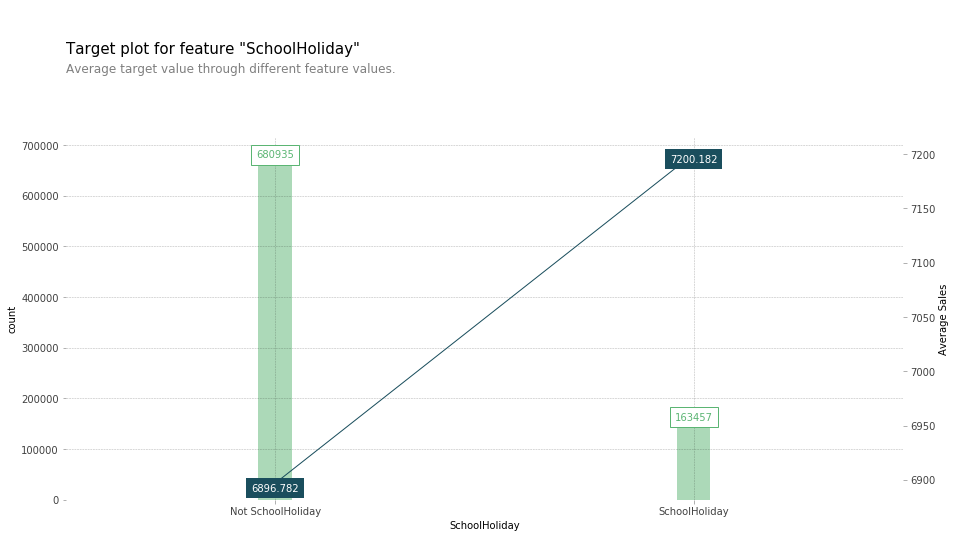

In [5]:
fig, axes, summary_df = info_plots.target_plot(
    df=ross_data, feature='SchoolHoliday', feature_name='SchoolHoliday', target=ross_target
)
_ = axes['bar_ax'].set_xticklabels(['Not SchoolHoliday', 'SchoolHoliday'])

In [6]:
summary_df

,x,display_column,count,Sales
0,0,SchoolHoliday_0,680935,6896.782411
1,1,SchoolHoliday_1,163457,7200.181650


## 1.2 check prediction distribution through feature 'SchoolHoliday'

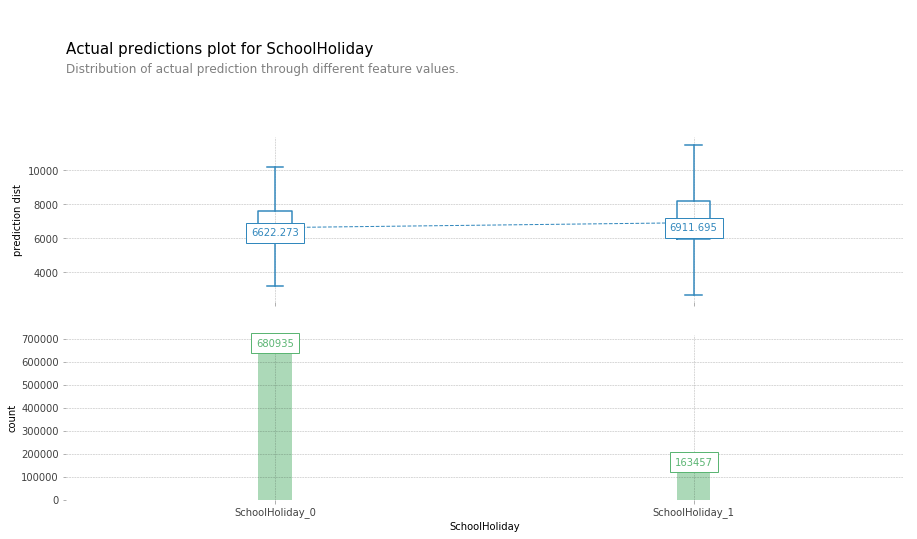

In [7]:
fig, axes, summary_df = info_plots.actual_plot(
    model=ross_model, X=ross_data[ross_features], feature='SchoolHoliday', feature_name='SchoolHoliday'
)

In [8]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,SchoolHoliday_0,680935,5828.145813,6622.272652,7577.496478
1,1,SchoolHoliday_1,163457,5941.953128,6911.694636,8157.970575


## 1.3 pdp for feature 'SchoolHoliday'

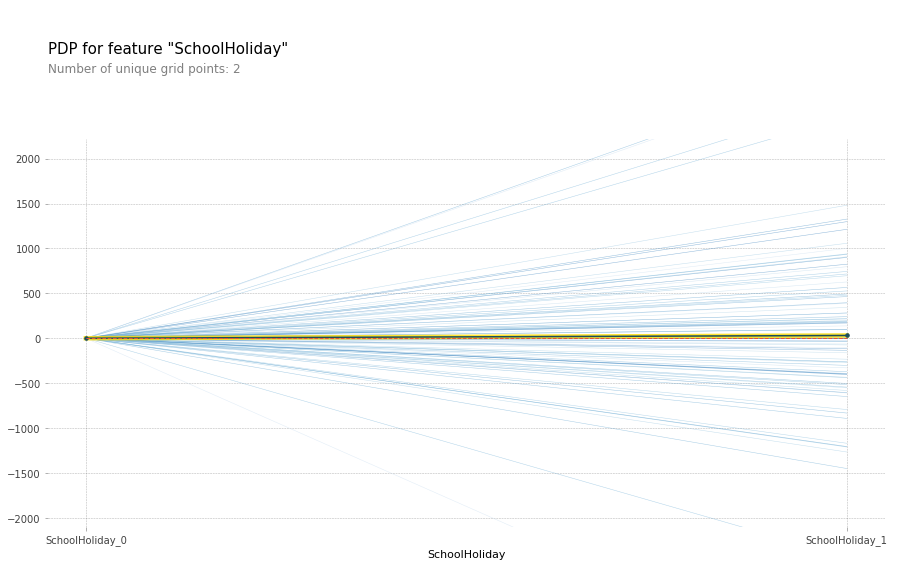

In [9]:
pdp_SchoolHoliday = pdp.pdp_isolate(
    model=ross_model, dataset=ross_data, model_features=ross_features, feature='SchoolHoliday'
)
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100)

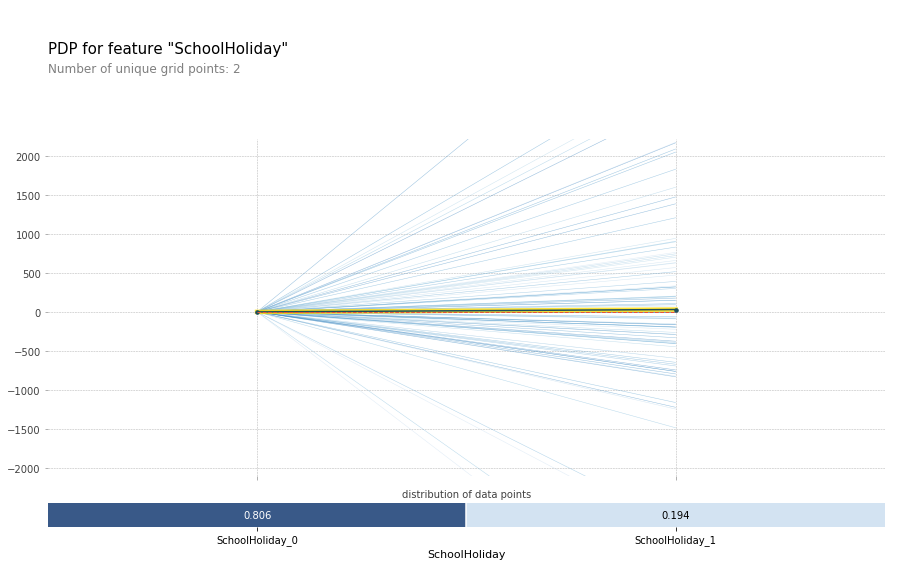

In [10]:
fig, axes = pdp.pdp_plot(pdp_SchoolHoliday, 'SchoolHoliday', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 2. one-hot encoding feature: StoreType

## 2.1 target distribution through feature 'StoreType'

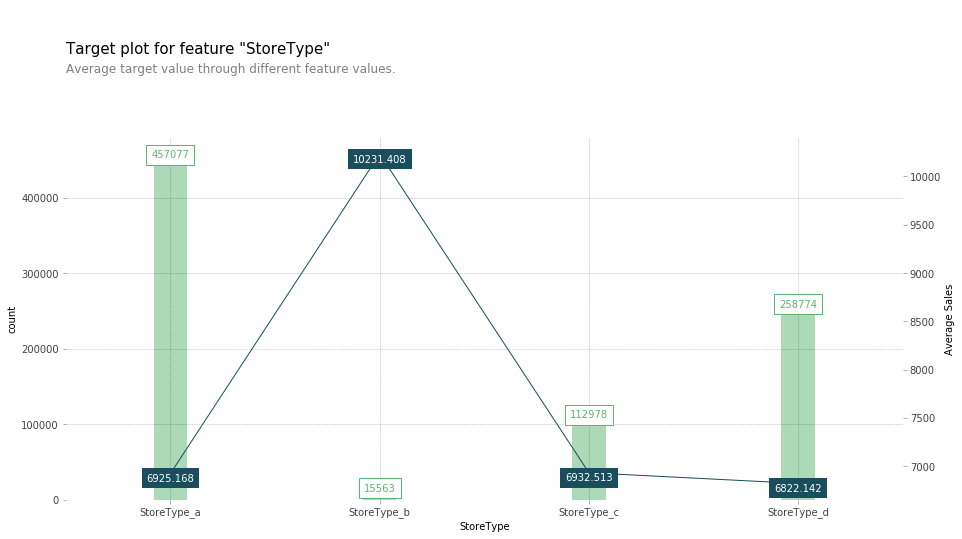

In [11]:
fig, axes, summary_df = info_plots.target_plot(
    df=ross_data, feature=['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], 
    feature_name='StoreType', target=ross_target
)

In [12]:
summary_df

,x,display_column,count,Sales
0,0,StoreType_a,457077,6925.167661
1,1,StoreType_b,15563,10231.407505
2,2,StoreType_c,112978,6932.512755
3,3,StoreType_d,258774,6822.141881


## 2.2 check prediction distribution through feature 'StoreType'

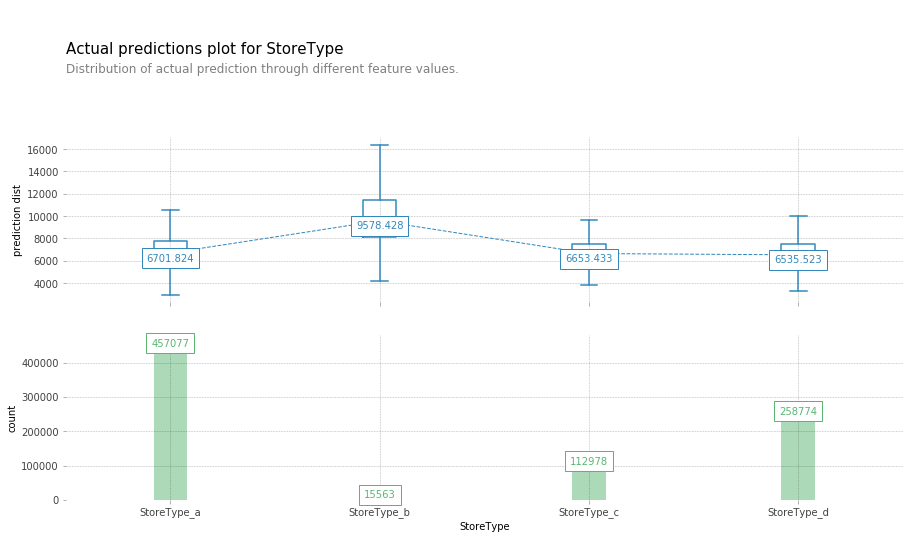

In [13]:
fig, axes, summary_df = info_plots.actual_plot(
    model=ross_model, X=ross_data[ross_features], 
    feature=['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d'], feature_name='StoreType'
)

In [14]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,StoreType_a,457077,5822.815972,6701.824226,7730.564152
1,1,StoreType_b,15563,8155.860114,9578.427701,11443.330958
2,2,StoreType_c,112978,6007.973935,6653.432827,7470.281513
3,3,StoreType_d,258774,5827.154238,6535.522843,7502.296154


## 2.3 pdp for feature 'StoreType'

CPU times: user 11.3 s, sys: 1.22 s, total: 12.6 s
Wall time: 5.39 s


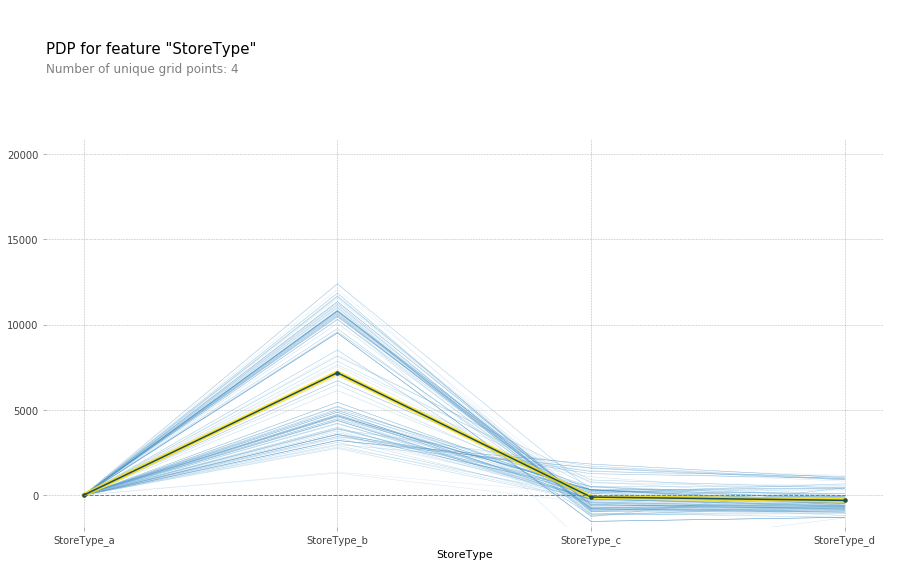

In [15]:
%%time
pdp_StoreType = pdp.pdp_isolate(
    model=ross_model, dataset=ross_data, model_features=ross_features, 
    feature=['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']
)
fig, axes = pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_lines=True, frac_to_plot=100)

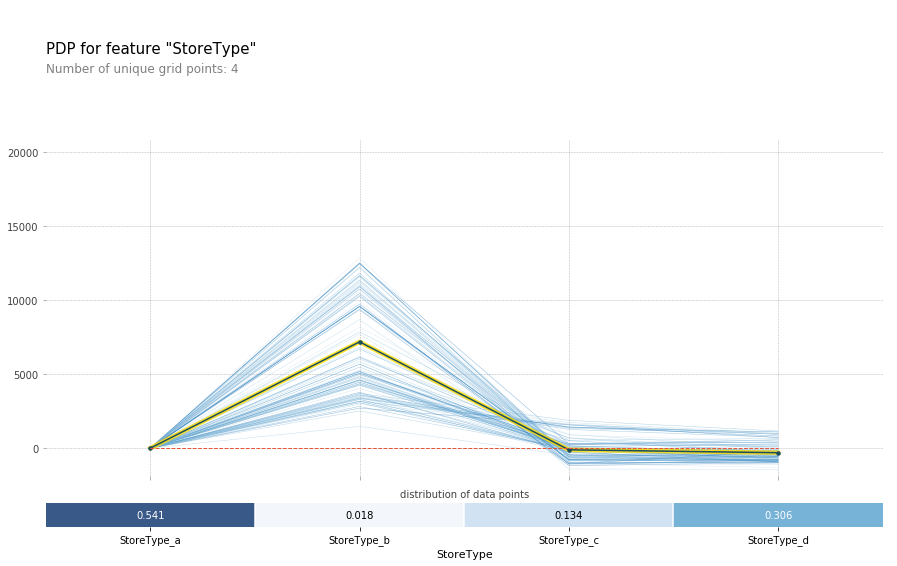

In [16]:
fig, axes = pdp.pdp_plot(pdp_StoreType, 'StoreType', plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 3. numeric feature: weekofyear

## 3.1 target distribution through feature 'weekofyear'

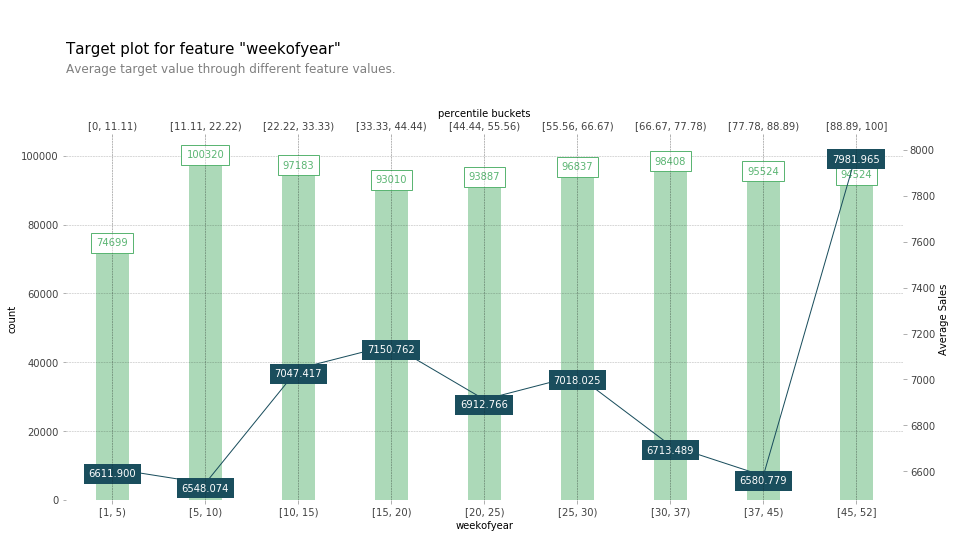

In [17]:
fig, axes, summary_df = info_plots.target_plot(
    df=ross_data, feature='weekofyear', feature_name='weekofyear', target=ross_target, show_percentile=True
)

In [18]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,Sales
0,0,"[1, 5)",1.0,5.0,"[0, 11.11)",0.00,11.11,74699,6611.900307
1,1,"[5, 10)",5.0,10.0,"[11.11, 22.22)",11.11,22.22,100320,6548.074412
2,2,"[10, 15)",10.0,15.0,"[22.22, 33.33)",22.22,33.33,97183,7047.416801
3,3,"[15, 20)",15.0,20.0,"[33.33, 44.44)",33.33,44.44,93010,7150.762251
4,4,"[20, 25)",20.0,25.0,"[44.44, 55.56)",44.44,55.56,93887,6912.765740
5,5,"[25, 30)",25.0,30.0,"[55.56, 66.67)",55.56,66.67,96837,7018.025414
6,6,"[30, 37)",30.0,37.0,"[66.67, 77.78)",66.67,77.78,98408,6713.488893
7,7,"[37, 45)",37.0,45.0,"[77.78, 88.89)",77.78,88.89,95524,6580.778694
8,8,"[45, 52]",45.0,52.0,"[88.89, 100]",88.89,100.00,94524,7981.965109


## 3.2 check prediction distribution through feature 'weekofyear'

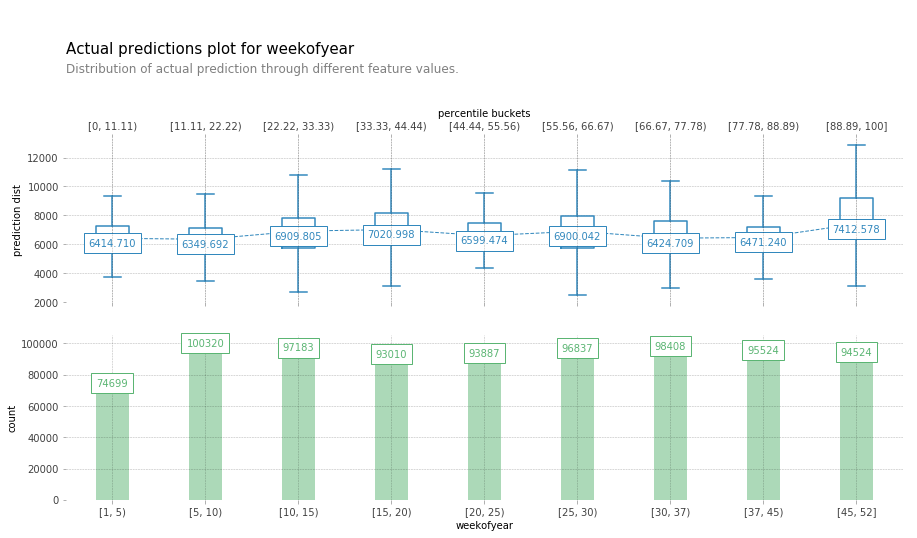

In [19]:
fig, axes, summary_df = info_plots.actual_plot(
    model=ross_model, X=ross_data[ross_features], feature='weekofyear', feature_name='weekofyear', 
    show_percentile=True
)

In [20]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[1, 5)",1.0,5.0,"[0, 11.11)",0.00,11.11,74699,5828.575845,6414.709793,7249.606068
1,1,"[5, 10)",5.0,10.0,"[11.11, 22.22)",11.11,22.22,100320,5571.090689,6349.691503,7150.833879
2,2,"[10, 15)",10.0,15.0,"[22.22, 33.33)",22.22,33.33,97183,5757.486750,6909.805470,7817.497664
3,3,"[15, 20)",15.0,20.0,"[33.33, 44.44)",33.33,44.44,93010,6130.498788,7020.997658,8159.699844
4,4,"[20, 25)",20.0,25.0,"[44.44, 55.56)",44.44,55.56,93887,6073.027208,6599.473723,7455.393664
5,5,"[25, 30)",25.0,30.0,"[55.56, 66.67)",55.56,66.67,96837,5746.654906,6900.042337,7928.553001
6,6,"[30, 37)",30.0,37.0,"[66.67, 77.78)",66.67,77.78,98408,5721.631257,6424.708778,7587.495796
7,7,"[37, 45)",37.0,45.0,"[77.78, 88.89)",77.78,88.89,95524,5713.472815,6471.239785,7180.184889
8,8,"[45, 52]",45.0,52.0,"[88.89, 100]",88.89,100.00,94524,6541.190649,7412.577743,9172.505219


## 3.3 pdp for feature 'weekofyear'

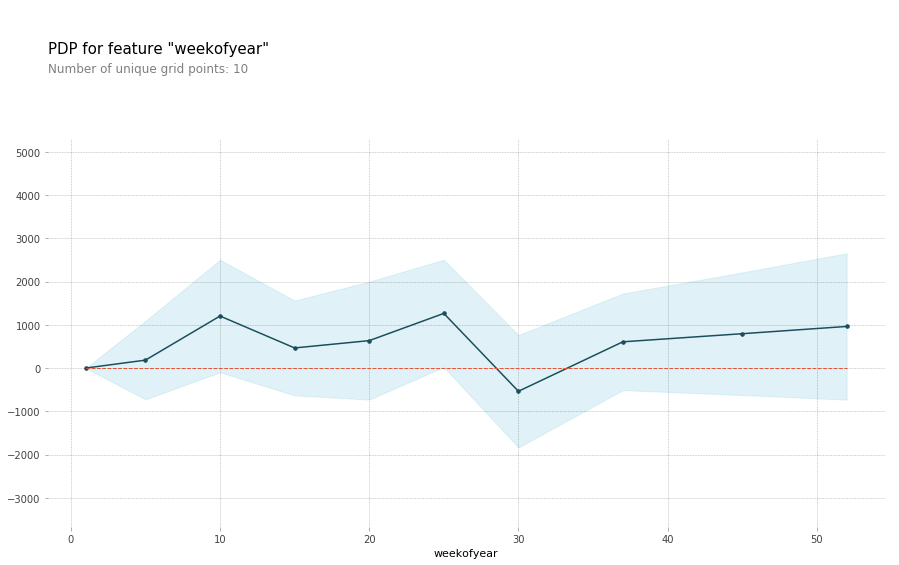

In [21]:
pdp_weekofyear = pdp.pdp_isolate(
    model=ross_model, dataset=ross_data, model_features=ross_features, feature='weekofyear'
)
fig, axes = pdp.pdp_plot(pdp_weekofyear, 'weekofyear')

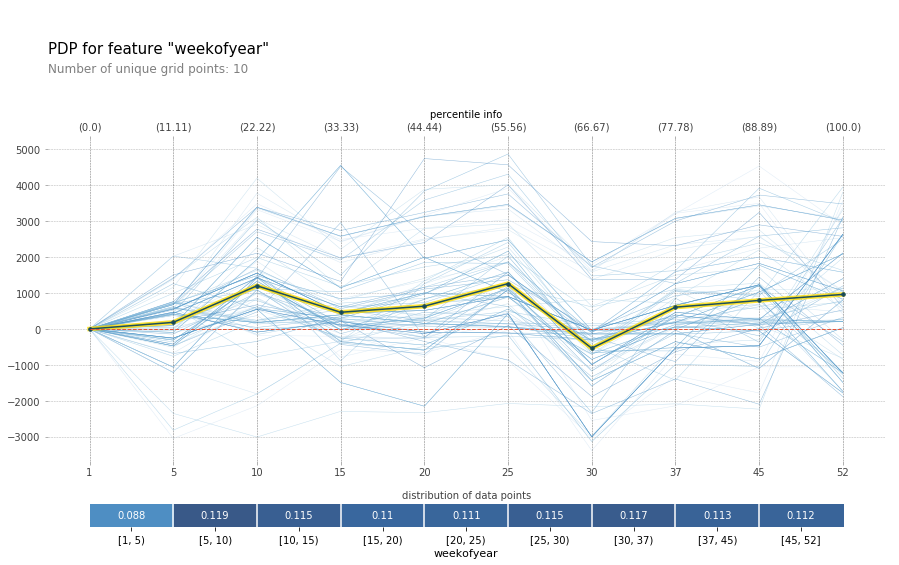

In [22]:
fig, axes = pdp.pdp_plot(
    pdp_weekofyear, 'weekofyear', plot_lines=True, frac_to_plot=100, x_quantile=True, 
    plot_pts_dist=True, show_percentile=True
)

# 4. Interaction between two variables: weekofyear and StoreType

## 4.1 target distribution through feature combination of 'weekofyear' and 'StoreType'

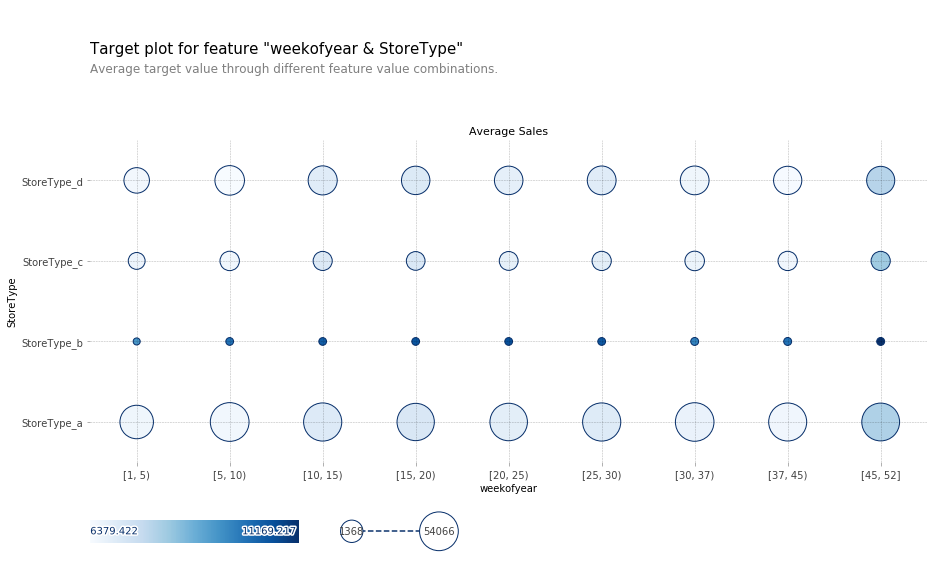

In [23]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=ross_data, features=['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']], 
    feature_names=['weekofyear', 'StoreType'], target=ross_target
)

In [24]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,count,Sales
0,0,0,"[1, 5)",StoreType_a,1.0,5.0,40316,6569.986060
1,0,1,"[1, 5)",StoreType_b,1.0,5.0,1368,9288.116959
2,0,2,"[1, 5)",StoreType_c,1.0,5.0,9866,6637.681026
3,0,3,"[1, 5)",StoreType_d,1.0,5.0,23149,6515.757830
4,1,0,"[5, 10)",StoreType_a,5.0,10.0,54066,6538.169718


## 4.2 prediction distribution through feature combination of 'weekofyear' and 'StoreType'

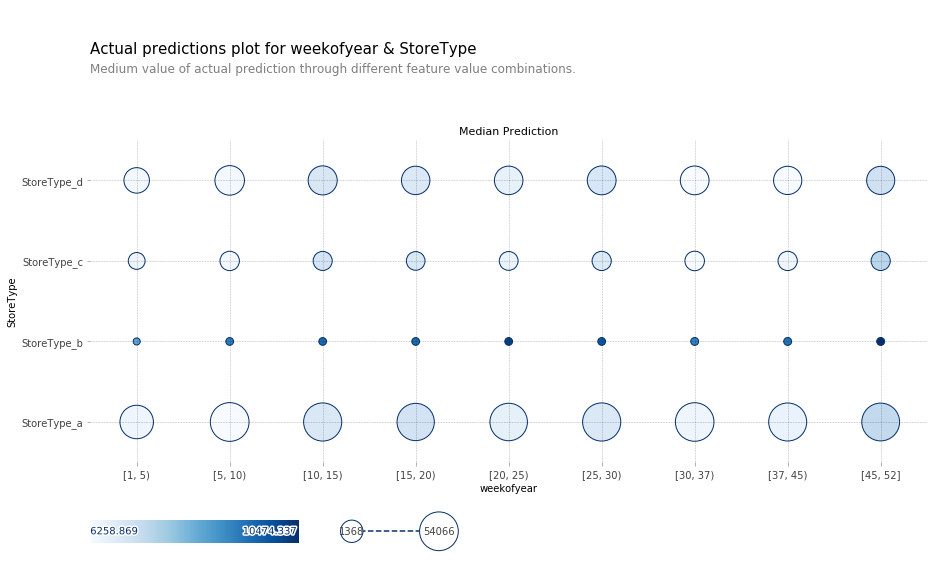

In [25]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=ross_model, X=ross_data[ross_features], 
    features=['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']], 
    feature_names=['weekofyear', 'StoreType']
)

In [26]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,0,"[1, 5)",StoreType_a,1.0,5.0,40316,5764.438163,6442.763004,7293.834595
1,0,1,"[1, 5)",StoreType_b,1.0,5.0,1368,7424.239747,8519.579900,10686.352088
2,0,2,"[1, 5)",StoreType_c,1.0,5.0,9866,6087.560179,6440.314179,6952.554776
3,0,3,"[1, 5)",StoreType_d,1.0,5.0,23149,5828.575845,6352.022564,6822.044315
4,1,0,"[5, 10)",StoreType_a,5.0,10.0,54066,5559.703968,6258.869377,7158.502533


## 4.3 pdp for feature combination of 'weekofyear' and 'StoreType'

In [28]:
%%time
inter_rf = pdp.pdp_interact(
    model=ross_model, dataset=ross_data, model_features=ross_features, 
    features=['weekofyear', ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']]
)

CPU times: user 2min 27s, sys: 14.4 s, total: 2min 42s
Wall time: 1min 7s


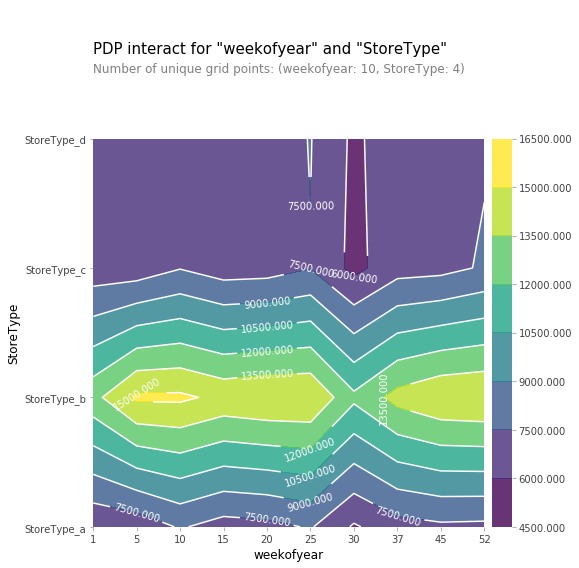

In [29]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['weekofyear', 'StoreType'], x_quantile=True, plot_type='contour', plot_pdp=False
)

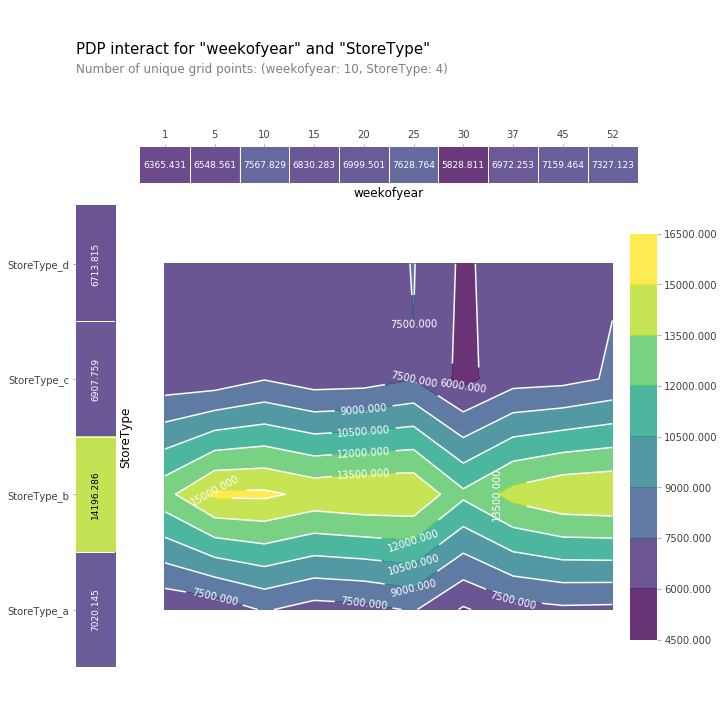

In [30]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['weekofyear', 'StoreType'], x_quantile=True, plot_type='contour', plot_pdp=True
)

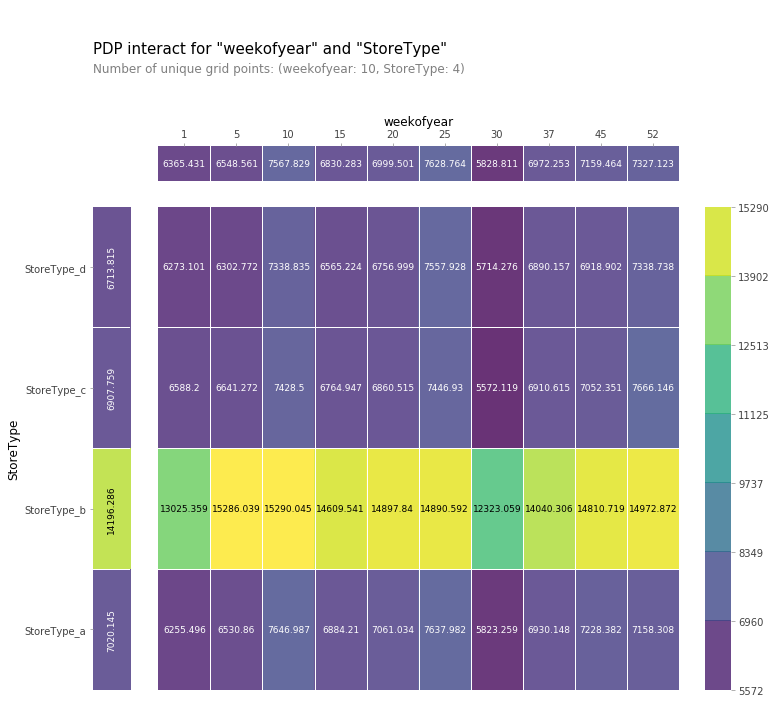

In [31]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['weekofyear', 'StoreType'], x_quantile=True, plot_type='grid', plot_pdp=True
)